In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.2 MB/s eta 0:00:00


In [ ]:
!pip install imagecodecs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tifffile as ti
import matplotlib.image as img
from osgeo import gdal
import matplotlib
import os
from PIL import Image
from ultralytics import YOLO

In [ ]:
import rasterio
import imagecodecs

In [ ]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O Pre_Event_San_Juan.tif

--2024-02-21 06:47:37--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘Pre_Event_San_Juan.tif’

Pre_Event_San_Juan.  93%[=================>  ] 904.22M  24.2MB/s    eta 3s     ^C


In [ ]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O Post_Event_San_Juan.tif

--2024-02-21 06:40:28--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘Post_Event_San_Juan.tif’

Post_Event_San_Juan 100%[===================>]   1.22G  5.27MB/s    in 3m 10s  

2024-02-21 06:43:52 (6.57 MB/s) - ‘Post_Event_San_Juan.tif’ saved [1310494499/1310494499]



In [ ]:
pre_event_image = 'drive/MyDrive/Pre_Event_San_Juan.tif'
post_event_image ='./Post_Event_San_Juan.tif'

In [ ]:
def load_visualize(image_path):
  with imagecodecs.imread(image_path) as src:
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
  fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(20,5))
  a1.imshow(red, cmap='Reds')
  a1.set_title('Red Band')
  a2.imshow(green, cmap='Greens')
  a2.set_title('Green band')
  a3.imshow(blue, cmap='Blues')
  a3.set_title('Blue Band')
plt.show()

In [ ]:
load_visualize(pre_event_image)

In [ ]:
load_and_visualize(post_event_image)

In [ ]:
#here try various combinations of gridsizes
def generate_tiles(input, output_dir, grid_x, grid_y):
  ds = gdal.Open(input)
  width = ds.RasterXSize
  height = ds.RasterYSize
  num_bands = ds.RasterCount

   # Calculate number of tiles in each dimension
  num_tiles_x = (width // grid_x)
  num_tiles_y = (height // grid_y)

  print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)
  for i in range(num_tiles_x):
      for j in range(num_tiles_y):
           x_offset = i *  grid_x
           y_offset = j *  grid_y

           tile_width = min(grid_x, width - x_offset)
           tile_height = min(grid_y, height - y_offset)
           tile = []
           for band in range(1, num_bands + 1):
               tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
               tile.append(tile_data)
            # Create output filename
           output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")

           # Create an output TIFF file with same CRS and band values range
           driver = gdal.GetDriverByName("GTiff")
           options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
           out_ds = driver.Create(output_file, tile_width, tile_height, num_bands,
                      ds.GetRasterBand(1).DataType, options=options)
           # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)
            # Set the geotransform
           geotransform = list(ds.GetGeoTransform())
           geotransform[0] = geotransform[0] + x_offset * geotransform[1]
           geotransform[3] = geotransform[3] + y_offset * geotransform[5]
           out_ds.SetGeoTransform(tuple(geotransform))
            # Set the projection
           out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
           for band in range(1, num_bands + 1):
               out_band = out_ds.GetRasterBand(band)
               out_band.WriteArray(tile[band - 1])

            # Close the output file
           out_ds = None

  print("Tiles generation completed.")


In [ ]:
input_file = "drive/MyDrive/Post_Event_San_Juan.tif"
output_dir = "drive/MyDrive/Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


In [ ]:
def tiff_to_jpeg(input_dir, output_dir):
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  for filename in os.listdir(input_dir):
    if filename.endswith('.tif'):
      img = Image.open(os.path.join(input_dir, filename))

      if img.mode != 'RGB':
        img = img.convert('RGB')
      output_filename = os.path.splitext(filename)[0]+ '.jpg'
      img.save(os.path.join(output_dir, output_filename), 'JPEG')
  print('conversion complete.')

input_dir = "drive/MyDrive/Post_Event_Grids_In_TIFF"
output_dir = "drive/MyDrive/Post_Event_Grids_In_JPEG"

In [ ]:
input_dir = "drive/MyDrive/Post_Event_Grids_In_TIFF"
output_dir = "drive/MyDrive/Post_Event_Grids_In_JPEG"
tiff_to_jpeg(input_dir,output_dir)

Streaming output truncated to the last 5000 lines.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conversion complete.
conv

In [ ]:
def rename(directory_path):
  directory_path = directory_path
  file = os.listdir(directory_path)
  prefix = "Post_event_"
  number = 0
  for filename in file:
    if os.path.isfile(os.path.join(directory_path, filename)):
      file_extension = os.path.splitext(filename)[1]
      new_filename = f"{prefix}{number:03}{file_extension}"
      old_filepath = os.path.join(directory_path, filename)
      new_filepath = os.path.join(directory_path, new_filename)
      os.rename(old_filepath, new_filepath)
      number += 1
  print("Renamed")

In [ ]:
rename(output_dir)

Renamed


In [ ]:
!pip install labelme2yolo

In [ ]:
!labelme2yolo --json_dir drive/MyDrive/Annotated


INFO:labelme2yolo:Searching label list from json files ...
INFO:labelme2yolo:Converting train set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--
INFO:labelme2yolo:Converting val set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--
INFO:labelme2yolo:Converting test set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--


In [ ]:
!pip install yolov8

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.3/723.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 623.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:


model = YOLO('yolov8n.pt')
model.info()

100%|██████████| 6.23M/6.23M [00:00<00:00, 62.3MB/s]


YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:
results = model.train(data='/content/drive/MyDrive/Annotated /YOLODataset/dataset.yaml', epochs=50, imgsz=512)

Ultralytics YOLOv8.1.38 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Annotated /YOLODataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 17.0MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Annotated /YOLODataset/labels/train... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]

train: New cache created: /content/drive/MyDrive/Annotated /YOLODataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Annotated /YOLODataset/labels/val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]

val: New cache created: /content/drive/MyDrive/Annotated /YOLODataset/labels/val.cache


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.935       4.13      1.705        199        512: 100%|██████████| 5/5 [01:00<00:00, 12.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.46s/it]

                   all         20        224    0.00238      0.079    0.00735    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.795      4.052      1.588        254        512: 100%|██████████| 5/5 [00:47<00:00,  9.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

                   all         20        224    0.00351      0.114    0.00546    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.608      3.772      1.389        221        512: 100%|██████████| 5/5 [00:47<00:00,  9.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

                   all         20        224    0.00506      0.162     0.0117    0.00534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.544      3.333      1.267        158        512: 100%|██████████| 5/5 [00:49<00:00,  9.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

                   all         20        224    0.00732      0.233     0.0295     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.557      3.208      1.273        203        512: 100%|██████████| 5/5 [00:49<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]

                   all         20        224    0.00802      0.255     0.0444     0.0199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.545      2.867      1.271        248        512: 100%|██████████| 5/5 [00:48<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]

                   all         20        224       0.01      0.316     0.0574      0.023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.582      2.558      1.284        222        512: 100%|██████████| 5/5 [00:47<00:00,  9.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]

                   all         20        224     0.0126      0.375     0.0786     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.578      2.477      1.272        199        512: 100%|██████████| 5/5 [00:47<00:00,  9.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

                   all         20        224     0.0229      0.634      0.123     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.512      2.354      1.244        154        512: 100%|██████████| 5/5 [00:49<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]

                   all         20        224      0.153      0.222      0.117     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.567      2.375      1.277        246        512: 100%|██████████| 5/5 [00:48<00:00,  9.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]

                   all         20        224     0.0225      0.609      0.109      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.562      2.215       1.25        206        512: 100%|██████████| 5/5 [00:55<00:00, 11.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]

                   all         20        224      0.138       0.23      0.123     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.544      2.146      1.243        202        512: 100%|██████████| 5/5 [00:47<00:00,  9.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.69s/it]

                   all         20        224      0.194      0.132      0.145     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.467      2.063      1.241        281        512: 100%|██████████| 5/5 [00:47<00:00,  9.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

                   all         20        224      0.188      0.222      0.168     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.539      2.141      1.279        212        512: 100%|██████████| 5/5 [00:48<00:00,  9.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]

                   all         20        224      0.173      0.284      0.164     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.464      2.039      1.241        273        512: 100%|██████████| 5/5 [00:49<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]

                   all         20        224       0.19      0.314      0.186     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.501       2.03      1.233        204        512: 100%|██████████| 5/5 [00:47<00:00,  9.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.44s/it]

                   all         20        224      0.156      0.322      0.163     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.428       2.02      1.217        183        512: 100%|██████████| 5/5 [00:46<00:00,  9.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

                   all         20        224      0.122      0.345      0.164     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.436      1.958      1.216        223        512: 100%|██████████| 5/5 [00:48<00:00,  9.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]

                   all         20        224      0.116      0.365      0.177     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.436      2.029      1.221        199        512: 100%|██████████| 5/5 [00:48<00:00,  9.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

                   all         20        224      0.136      0.397      0.198     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.464      1.924      1.252        206        512: 100%|██████████| 5/5 [00:48<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]

                   all         20        224      0.157      0.349       0.19        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G       1.41      1.882      1.235        186        512: 100%|██████████| 5/5 [00:47<00:00,  9.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.88s/it]

                   all         20        224      0.153      0.346      0.164     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.399      1.873      1.196        270        512: 100%|██████████| 5/5 [00:53<00:00, 10.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

                   all         20        224       0.16      0.422      0.158      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.405      1.863      1.238        289        512: 100%|██████████| 5/5 [00:47<00:00,  9.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]

                   all         20        224        0.2      0.408      0.179     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.372      1.918      1.211        233        512: 100%|██████████| 5/5 [00:49<00:00,  9.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

                   all         20        224      0.211      0.464      0.221      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.315      1.804      1.174        307        512: 100%|██████████| 5/5 [00:49<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]

                   all         20        224      0.217      0.446       0.24      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.356      1.801      1.219        211        512: 100%|██████████| 5/5 [00:46<00:00,  9.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

                   all         20        224      0.226      0.504      0.249       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.366      1.763      1.187        232        512: 100%|██████████| 5/5 [00:47<00:00,  9.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]

                   all         20        224      0.211      0.401      0.225      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.407      1.911       1.22        240        512: 100%|██████████| 5/5 [00:47<00:00,  9.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]

                   all         20        224      0.188       0.42       0.19     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.349      1.851      1.184        180        512: 100%|██████████| 5/5 [00:49<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]

                   all         20        224      0.212       0.37      0.194      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.318      1.733      1.157        289        512: 100%|██████████| 5/5 [00:49<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]

                   all         20        224      0.214      0.457      0.219       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.294      1.742      1.176        174        512: 100%|██████████| 5/5 [00:48<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.65s/it]

                   all         20        224      0.243      0.366      0.226      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.294      1.789      1.196        192        512: 100%|██████████| 5/5 [00:47<00:00,  9.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.48s/it]

                   all         20        224      0.197       0.47      0.216      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.295      1.746      1.204        176        512: 100%|██████████| 5/5 [00:50<00:00, 10.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]

                   all         20        224      0.209      0.432      0.224      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.295      1.699      1.181        216        512: 100%|██████████| 5/5 [00:48<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]

                   all         20        224      0.191       0.53       0.24      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G       1.34      1.765      1.191        174        512: 100%|██████████| 5/5 [00:49<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

                   all         20        224      0.188      0.519      0.261      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.276      1.649      1.155        218        512: 100%|██████████| 5/5 [00:48<00:00,  9.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]

                   all         20        224      0.224      0.466      0.285      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.262      1.708      1.142        345        512: 100%|██████████| 5/5 [00:47<00:00,  9.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]

                   all         20        224      0.241      0.518      0.288      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.261      1.631      1.156        229        512: 100%|██████████| 5/5 [00:49<00:00,  9.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]

                   all         20        224       0.25      0.527       0.29      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.249      1.694      1.161        174        512: 100%|██████████| 5/5 [00:47<00:00,  9.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

                   all         20        224       0.24      0.539      0.286      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.235      1.597      1.152        200        512: 100%|██████████| 5/5 [00:49<00:00,  9.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]

                   all         20        224      0.246      0.451      0.269      0.158


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.249      1.753      1.186        131        512: 100%|██████████| 5/5 [00:50<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

                   all         20        224      0.218      0.446      0.261      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.226      1.738      1.166        132        512: 100%|██████████| 5/5 [00:46<00:00,  9.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]

                   all         20        224      0.263      0.379      0.258      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.199      1.689      1.157        137        512: 100%|██████████| 5/5 [00:45<00:00,  9.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

                   all         20        224      0.245      0.408      0.256       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.171      1.653       1.14        156        512: 100%|██████████| 5/5 [00:46<00:00,  9.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]

                   all         20        224      0.248      0.478       0.26      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.225      1.692      1.144        200        512: 100%|██████████| 5/5 [00:45<00:00,  9.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

                   all         20        224      0.243       0.52      0.259      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.176      1.643      1.127        122        512: 100%|██████████| 5/5 [00:49<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

                   all         20        224      0.253      0.513      0.259      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.205      1.645      1.163        127        512: 100%|██████████| 5/5 [00:48<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

                   all         20        224      0.255      0.489      0.268      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.171      1.675      1.141        122        512: 100%|██████████| 5/5 [00:46<00:00,  9.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]

                   all         20        224      0.266      0.469      0.284      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.161      1.612      1.128        154        512: 100%|██████████| 5/5 [00:45<00:00,  9.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

                   all         20        224      0.281      0.499      0.292      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.132       1.62      1.139        138        512: 100%|██████████| 5/5 [00:46<00:00,  9.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]

                   all         20        224      0.275      0.491      0.303      0.179



50 epochs completed in 0.754 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.1.38 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]


                   all         20        224      0.274      0.497      0.303      0.179
undamagedresidentialbuilding         20         39      0.269      0.205      0.169     0.0768
damagedresidentialbuilding         20         84       0.27      0.333      0.248       0.13
undamagedcommercialbuilding         20         43      0.363      0.675      0.496      0.313
damagedcommercialbuilding         20         58      0.193      0.776        0.3      0.195
Speed: 1.6ms preprocess, 227.8ms inference, 0.0ms loss, 18.1ms postprocess per image
Results saved to runs/detect/train7


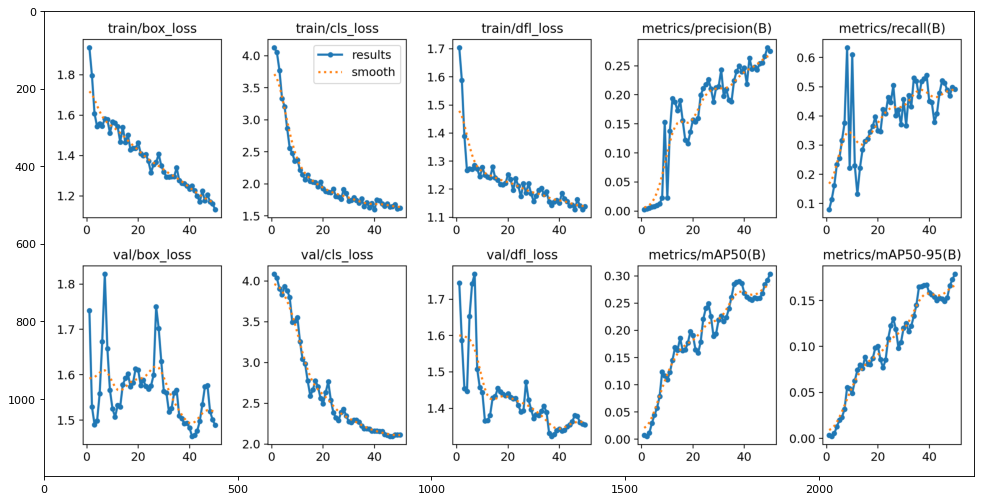

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
# reading the image
results = img.imread('runs/detect/train7/results.png')
# displaying the image
plt.imshow(results)

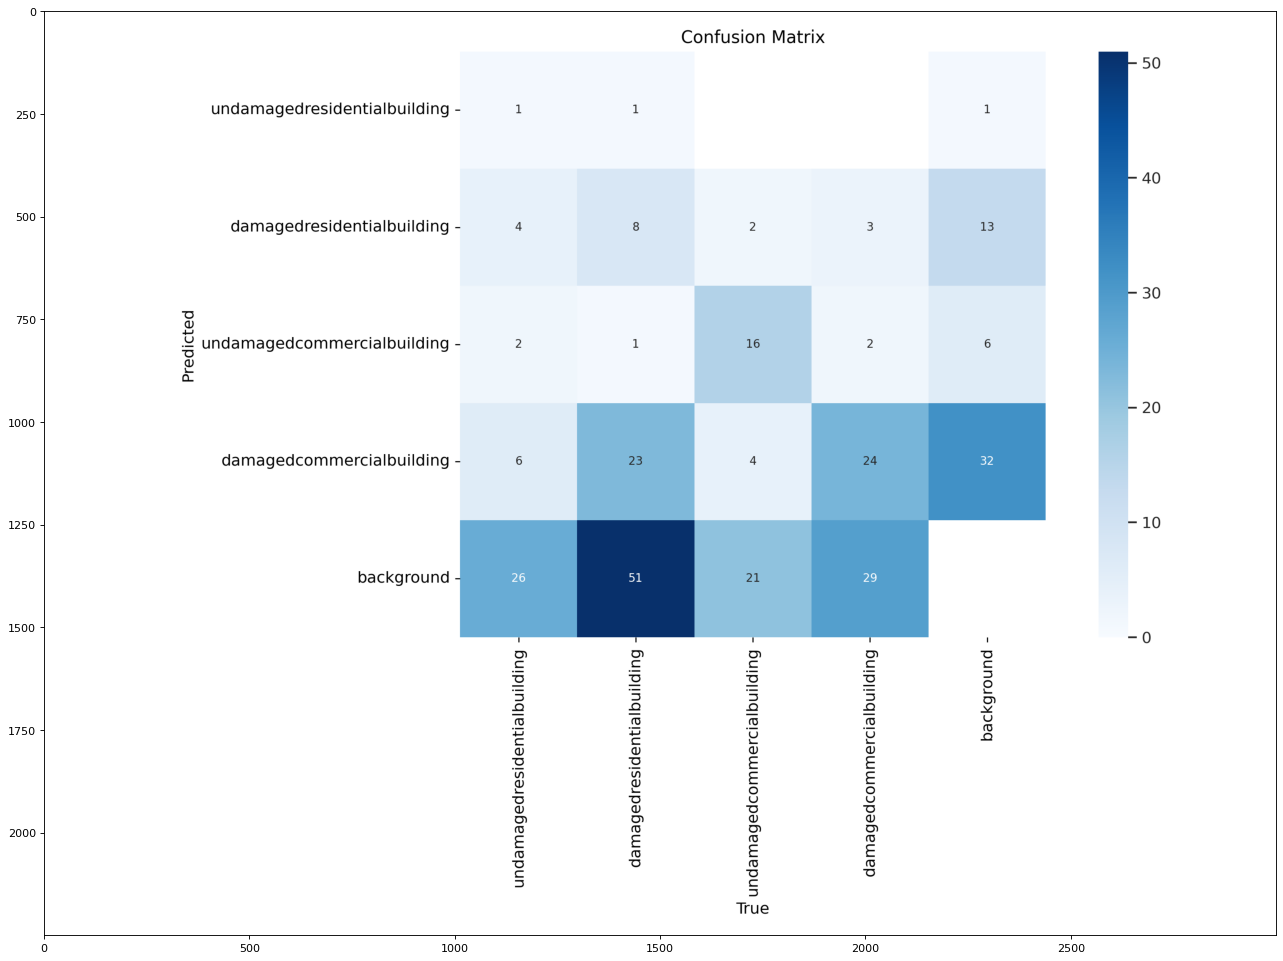

In [ ]:
plt.figure(figsize=(20,15), dpi=80)
# reading the image
cf = img.imread('runs/detect/train7/confusion_matrix.png')
# displaying the image
plt.imshow(cf)

In [ ]:
model = YOLO('/content/runs/detect/train7/weights/best.pt')

In [ ]:
from IPython.display import Image, display


0: 512x512 7 undamagedcommercialbuildings, 4 damagedcommercialbuildings, 225.6ms
1: 512x512 1 damagedresidentialbuilding, 1 undamagedcommercialbuilding, 2 damagedcommercialbuildings, 225.6ms
2: 512x512 1 undamagedresidentialbuilding, 2 undamagedcommercialbuildings, 225.6ms
3: 512x512 3 undamagedresidentialbuildings, 1 damagedresidentialbuilding, 3 undamagedcommercialbuildings, 4 damagedcommercialbuildings, 225.6ms
4: 512x512 1 undamagedresidentialbuilding, 1 damagedresidentialbuilding, 1 undamagedcommercialbuilding, 1 damagedcommercialbuilding, 225.6ms
Speed: 2.5ms preprocess, 225.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


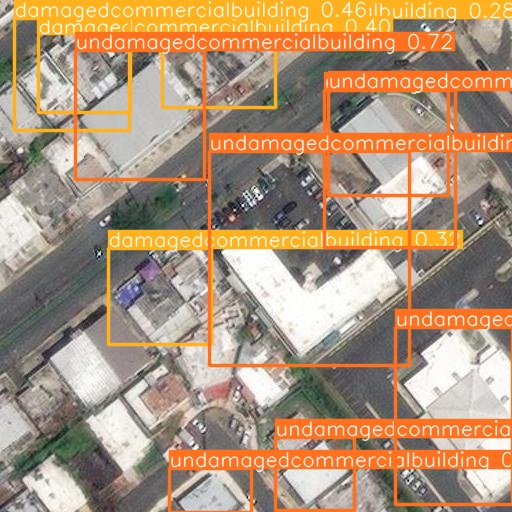

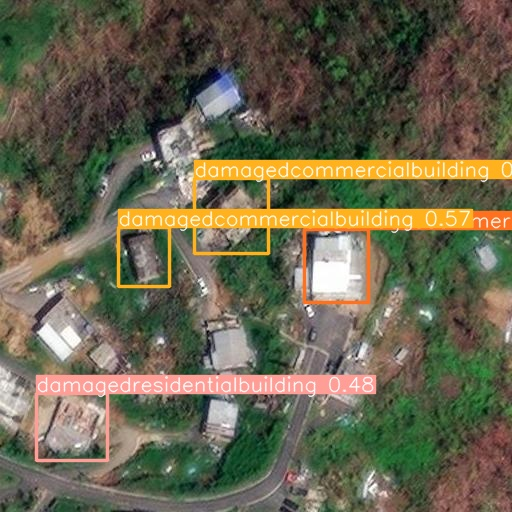

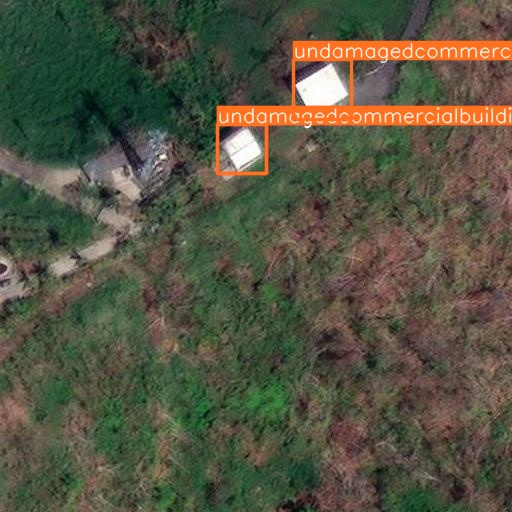

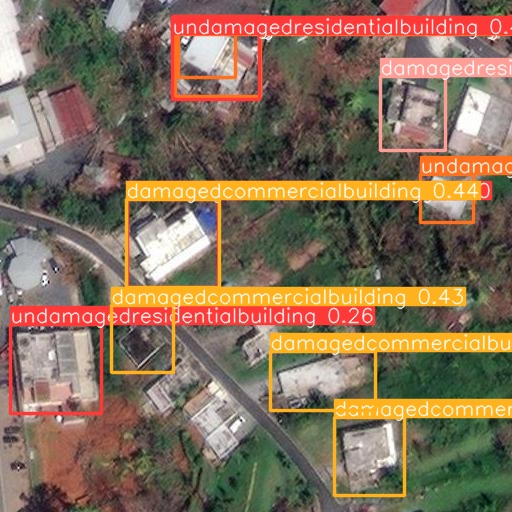

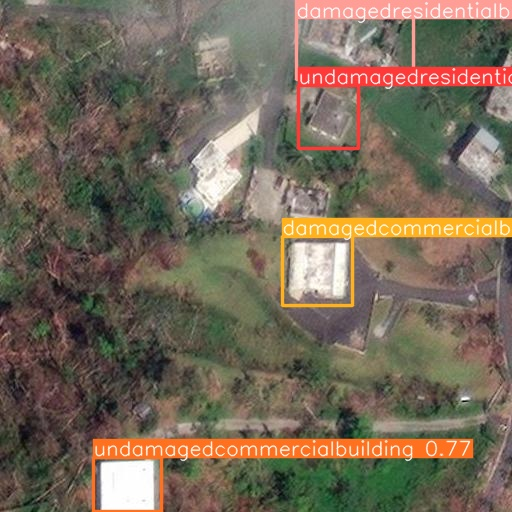

In [ ]:
results = model(['/content/drive/MyDrive/Post_Event_Grids_In_JPEG/Post_event_268.jpg', '/content/drive/MyDrive/Post_Event_Grids_In_JPEG/Post_event_001.jpg', '/content/drive/MyDrive/Post_Event_Grids_In_JPEG/Post_event_018.jpg','/content/drive/MyDrive/Post_Event_Grids_In_JPEG/Post_event_461.jpg', '/content/drive/MyDrive/Post_Event_Grids_In_JPEG/Post_event_877.jpg'])

for idx, result in enumerate(results):
    try:
        # Assuming 'result' has attributes like 'boxes', 'masks', 'keypoints', and 'probs'
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs

        # Display the result (assuming 'show()' is a valid method)
        result.show()  # display to screen

        # Save the image using the filename derived from 'result'
        image_filename = f'result_{idx}.jpg'
        result.save(filename=image_filename)

        # Display the saved image inline
        display(Image(image_filename))

    except Exception as e:
        print(f"Error displaying image: {e}")

